## Import Library

In [1]:
import numpy as np # linear algebra 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error 
plt.style.use('fivethirtyeight')

## Import Data and do preprocessing
The data we will be using is hourly power consumption data from PJM. Energy consumtion has some unique charachteristics. It will be interesting to see how prophet picks them up.

Pulling the PJM East which has data from 2002-2018 for the entire east region.

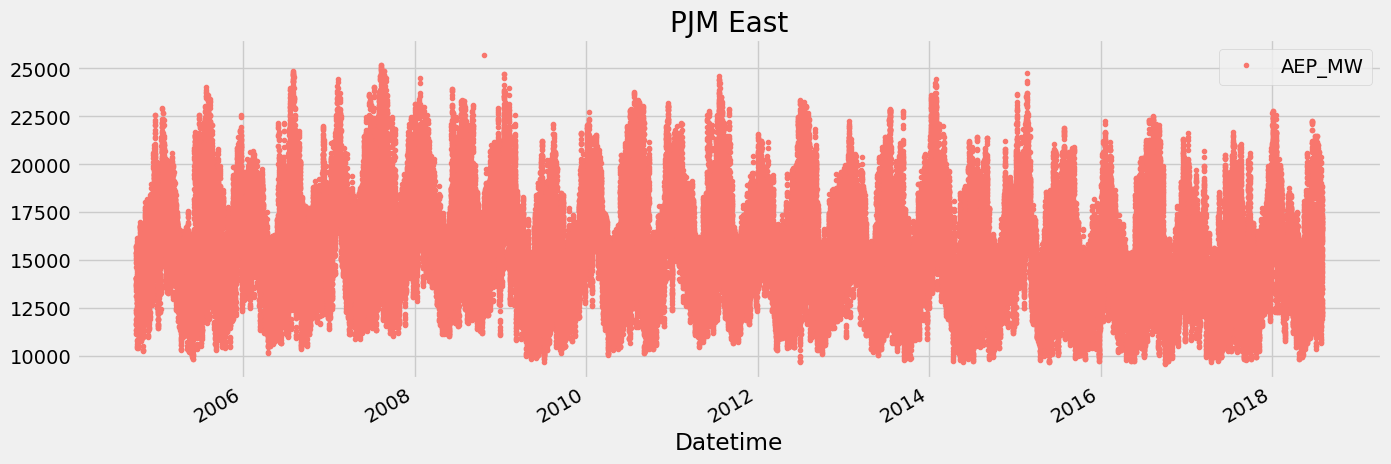

In [2]:
pjme = pd.read_csv('D:/[DOC]/MASH_/20250206/AEP_hourly.csv', index_col=[0], parse_dates=[0])
pjme = pjme.sort_index()
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

In [3]:
pjme.head()

,AEP_MW
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0


## Train/Test Split
Cut off the data after 2015 to use as our validation set.

In [4]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

In [5]:
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

In [36]:
time_step = 24  # 使用前24小时的数据预测下一个小时的数据
pjme_X_train, pjme_y_train = create_dataset(pjme_train.values, time_step)
pjme_X_test, pjme_y_test = create_dataset(pjme_test.values, time_step)
pjme_y_train.shape, pjme_y_test.shape

((89809,), (31414,))

In [39]:
pjme_train_ = pd.DataFrame(pjme_train.iloc[0 + time_step : -1, 0])
pjme_test_ = pd.DataFrame(pjme_test.iloc[0 + time_step : -1, 0])
pjme_train_.shape, pjme_test_.shape

((89809, 1), (31414, 1))

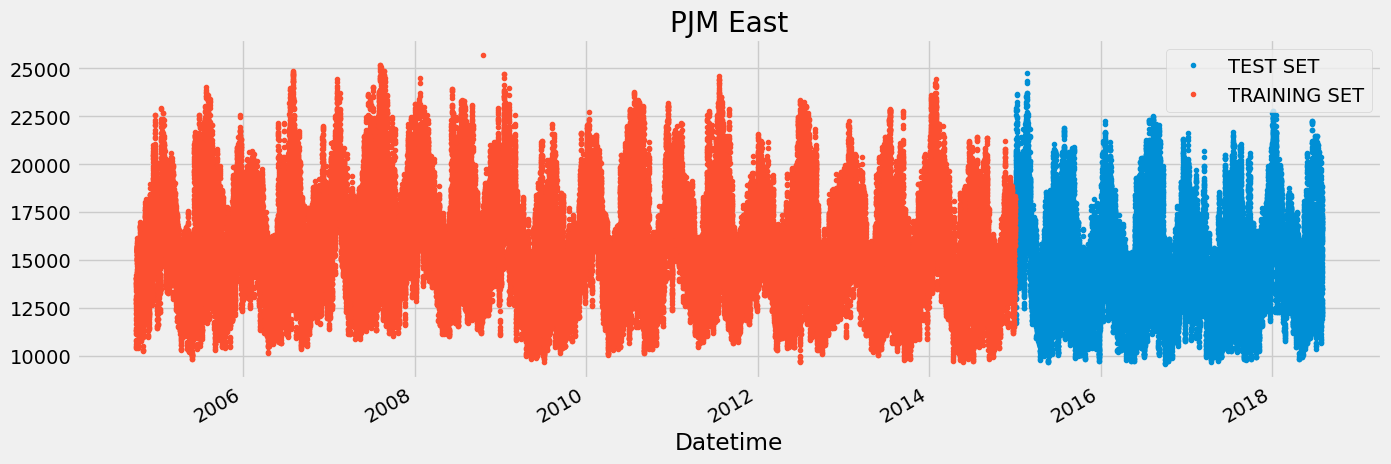

In [34]:
_ = pjme_test_.rename(columns={'AEP_MW': 'TEST SET'}).join(pjme_train_.rename(columns={'AEP_MW': 'TRAINING SET'}), how='outer').plot(figsize=(15,5), title='PJM East', style='.')

## Create Time Series Features

In [40]:
# 归一化
scaler = MinMaxScaler(feature_range=(0, 1))
sc_pjme_train = scaler.fit_transform(pjme_train)
sc_pjme_test = scaler.transform(pjme_test)
X_train, y_train = create_dataset(sc_pjme_train, time_step)
X_test, y_test = create_dataset(sc_pjme_test, time_step)

In [41]:
# 重塑输入数据为 [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [42]:
# 构建LSTM模型, 包含2个LSTM层和1个全连接层
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

D:\ProgramData\anaconda3\envs\py39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [43]:
# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error')

In [44]:
# 训练模型
model.fit(X_train, y_train, batch_size=64, epochs=20)

Epoch 1/20
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 49s 30ms/step - loss: 0.0081
Epoch 2/20
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - loss: 4.0861e-04
Epoch 3/20
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - loss: 3.8134e-04
Epoch 4/20
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - loss: 3.7365e-04
Epoch 5/20
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 3.4615e-04
Epoch 6/20
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - loss: 2.9863e-04
Epoch 7/20
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - loss: 2.7665e-04
Epoch 8/20
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - loss: 2.9072e-04
Epoch 9/20
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - loss: 2.3599e-04
Epoch 10/20
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - loss: 2.2660e-04
Epoch 11/20
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - loss: 2.1645e-04
Epoch 12/20
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - loss: 2.0163e-04
Epoch 13/20
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - loss: 2.0146e-04
Epoch 14/20
1404/1404 ━━━

## Forecast on Test Set

In [45]:
# 预测
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# 反归一化
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
train_predict.shape, test_predict.shape

2807/2807 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step
982/982 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


((89809, 1), (31414, 1))

In [46]:
pjme_test_['MW_Prediction'] = test_predict
pjme_train_['MW_Prediction'] = train_predict
pjme_all = pd.concat([pjme_test_, pjme_train_], sort=False)

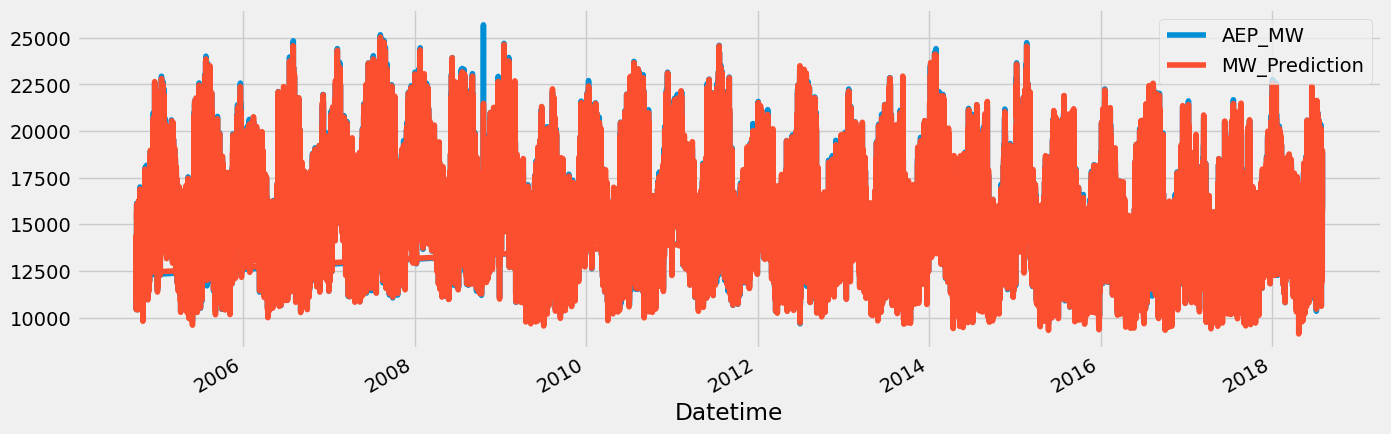

In [47]:
_ = pjme_all[['AEP_MW','MW_Prediction']].plot(figsize=(15, 5))

## Look at first month of predictions

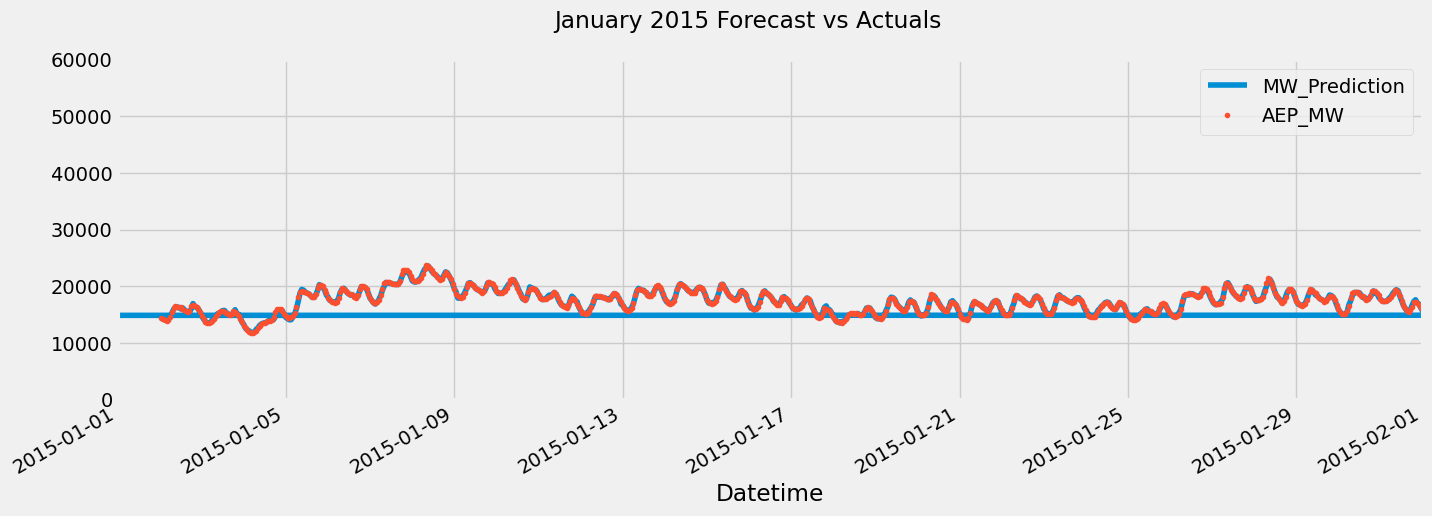

In [48]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

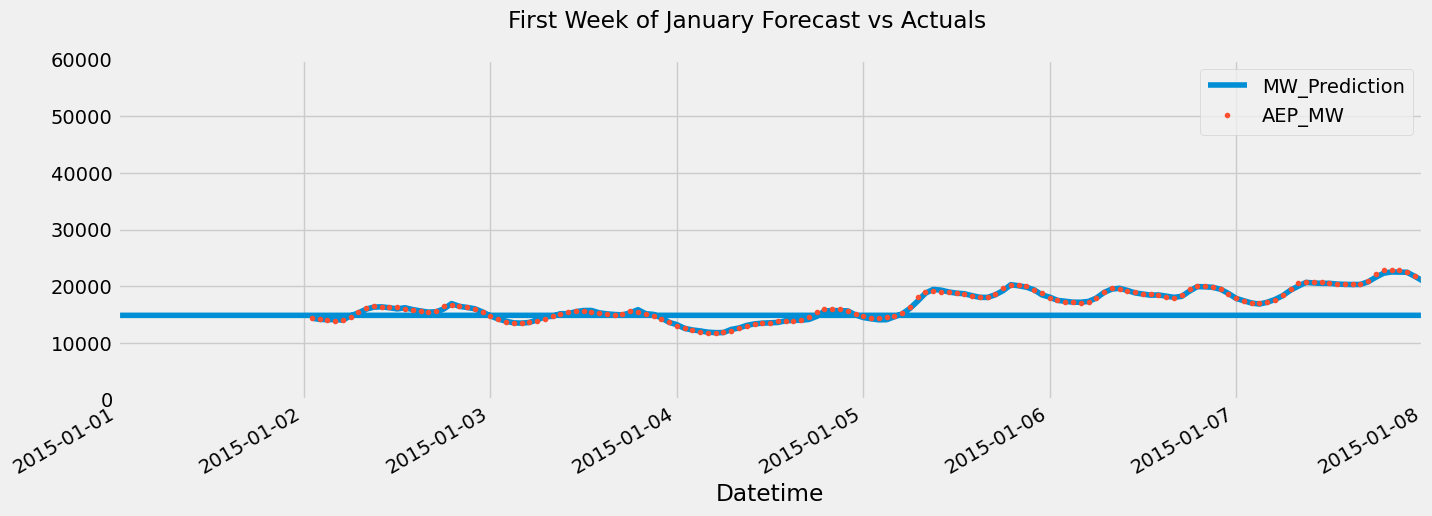

In [49]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

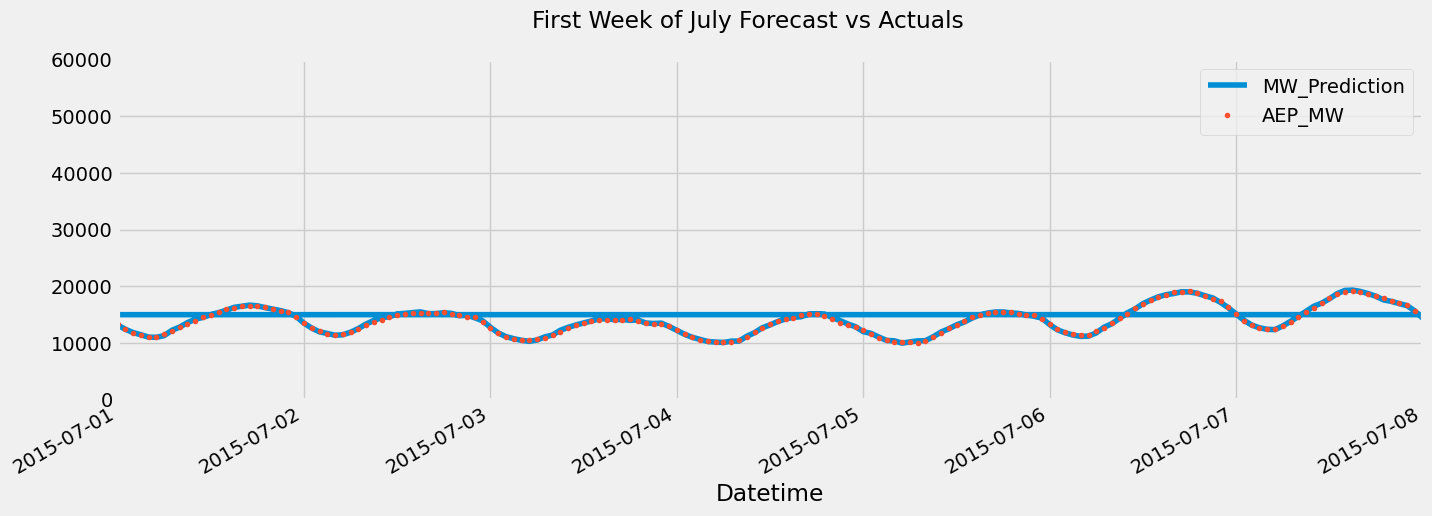

In [50]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

## Error Metrics On Test Set
Our RMSE error is ?

Our MAE error is ?

Our MAPE error is ?

In [52]:
mean_squared_error(y_true=pjme_test_['AEP_MW'], y_pred=pjme_test_['MW_Prediction'])

35694.33111527159

In [53]:
mean_absolute_error(y_true=pjme_test_['AEP_MW'], y_pred=pjme_test_['MW_Prediction'])

136.6746004468549

I like using mean absolute percent error because it gives an easy to interperate percentage showing how off the predictions are. MAPE isn't included in sklearn so we need to use a custom function.

In [54]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [55]:
mean_absolute_percentage_error(y_true=pjme_test_['AEP_MW'], y_pred=pjme_test_['MW_Prediction'])

0.9406721885010325

## Look at Worst and Best Predicted Days

In [1]:
# X为所有可用时间解释的变量(feature)；可只考虑较重要的特征维度，或采用降维后特征; 创建数据集
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
##    df['hour'] = df['date'].dt.hour  # 如果不降采样, 数据粒度会过高，VARMAX 模型会消耗大量内存，训练时间会大于1小时
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
##    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[[label,'dayofweek','quarter','month','year', 'dayofyear','dayofmonth']]
    return X

In [ ]:
pjme_test_['error'] = pjme_test_['AEP_MW'] - pjme_test_['MW_Prediction']
pjme_test_['abs_error'] = pjme_test_['error'].apply(np.abs)
pjme_test_ = create_features(pjme_test_)
error_by_day = pjme_test_.groupby(['year','month','dayofmonth']).mean()[['AEP_MW','MW_Prediction','error','abs_error']]

In [67]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

AEP_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2016 9     11          13426.416667   13549.828125 -123.411377  192.906982
     8     6           16082.833333   16184.290039 -101.457520  153.321126
2017 8     4           15191.958333   15293.358398 -101.399658  142.652425
2018 2     3           17782.083333   17883.216797 -101.132161  138.149577
2016 6     12          14828.166667   14925.496094  -97.329305  187.446737
     12    17          15788.000000   15884.907227  -96.907756  179.737996
2018 7     6           15742.916667   15838.293945  -95.377441  157.277018
           20          15332.500000   15427.684570  -95.184367  108.902222
2016 1     30          14928.458333   15023.487305  -95.028768  119.865194
2017 2     11          13688.708333   13782.933594  -94.225708  162.421265

Notice anything about the over forecasted days?

<li> worst day - July 4th, 2016 - is a holiday. </li>
<li> worst day - December 25, 2015 - Christmas. </li>
<li> worst day - July 4th, 2016 - is a holiday. </li>
Looks like our model may benefit from adding a holiday indicator.

In [68]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

AEP_MW  MW_Prediction      error   abs_error
year month dayofmonth                                                    
2015 12    27          11998.916667   11960.305664  38.610352  523.362223
2018 4     24          11723.750000   11667.937500  55.811849  419.426351
2015 11    25          13307.708333   13359.946289 -52.237996  333.330770
           26          11718.500000   11709.555664   8.944417  332.846354
2018 4     25          13224.666667   13159.954102  64.711751  288.960531
2017 8     21          17295.166667   17232.824219  62.342285  262.657145
2016 1     11          18406.625000   18336.402344  70.222168  256.988932
2018 4     18          14465.916667   14502.073242 -36.156169  254.348389
2015 11    27          11755.083333   11708.679688  46.403687  242.421997
     9     3           17202.666667   17198.732422   3.933675  236.823893

The best predicted days seem to be a lot of Dec. (not many holidays and mild weather) Also early may

In [69]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

AEP_MW  MW_Prediction      error  abs_error
year month dayofmonth                                                   
2017 7     24          16343.333333   16352.616211  -9.281942  75.642782
2016 4     30          11754.708333   11760.631836  -5.923177  76.184082
2018 3     3           14561.500000   14572.750000 -11.250041  77.452271
     2     6           17551.708333   17559.708984  -8.001546  79.596924
2016 2     23          15012.625000   15005.230469   7.394084  80.866821
2015 6     30          14300.666667   14284.644531  16.022095  81.101034
2017 7     3           15035.250000   15071.868164 -36.618123  81.483032
     5     24          13192.416667   13193.793945  -1.377686  81.936117
2018 4     15          12256.791667   12256.406250   0.385457  83.452596
     3     28          14003.875000   14007.782227  -3.908040  83.744222

Plotting some best/worst predicted days

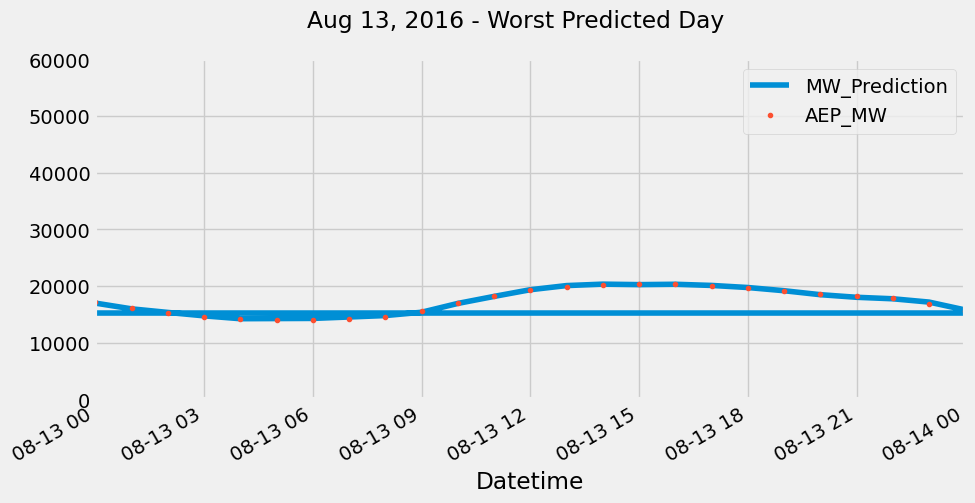

In [70]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

This one is pretty impressive. SPOT ON!

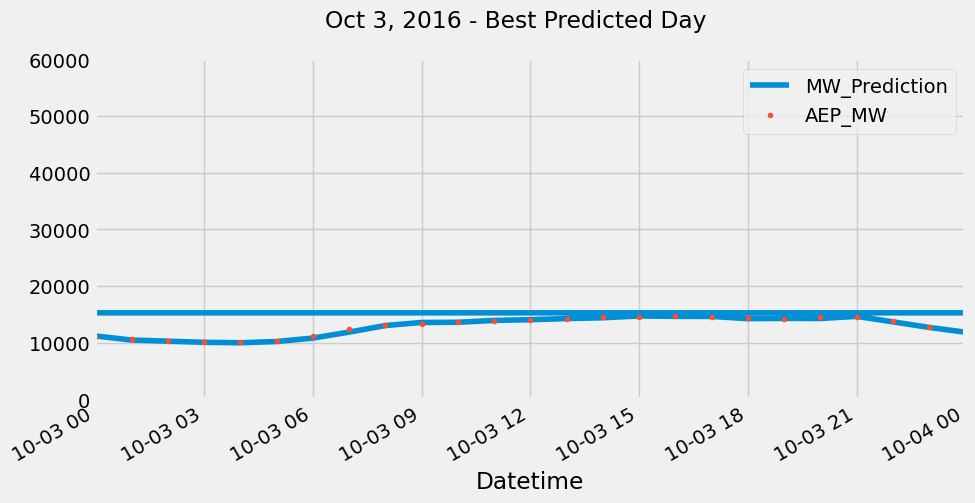

In [71]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')

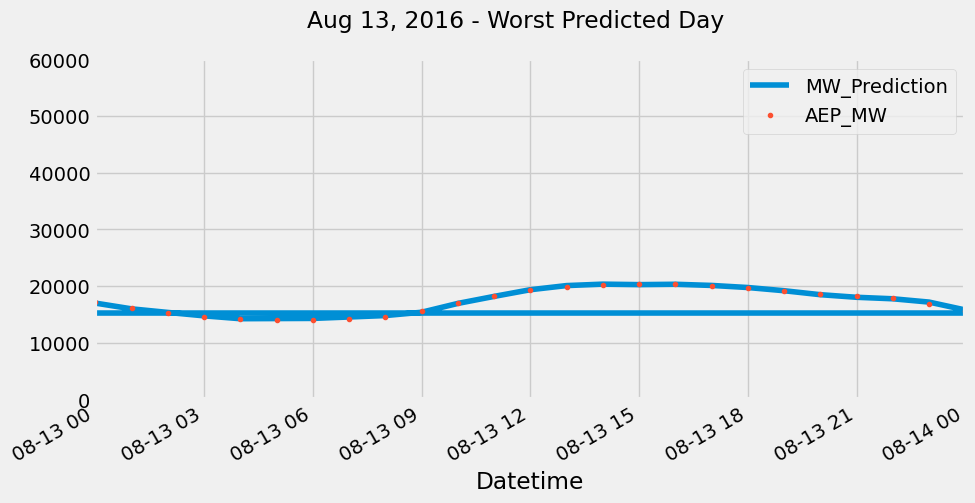

In [72]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

## Up next?
<li>Add Lag variables.</li>
<li>Add holiday indicators.</li>
<li>Add weather data source.</li>